<a href="https://colab.research.google.com/github/oliverquintana/CerebralTumorClasification/blob/master/TumorConvAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor Segmentation for Brain MR Images


# Load libraries

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load Dataset

1156 Training Images

*   578 Brain MRI 
*   578 Tumor masks

126 Validation Images

*   63 Brain MRI 
*   63 Tumor masks

In [0]:
def get_images(mypath, size = 356, channels = 3):

    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    onlyfiles.sort()
    images = np.empty(len(onlyfiles), dtype=object)
    images = np.zeros((len(onlyfiles), size, size, channels))

    for n in range(len(onlyfiles)):
        images[n] = cv2.imread( join(mypath,onlyfiles[n]))
        #images[n] = cv2.resize(temp, (size, size), interpolation = cv2.INTER_AREA)
        
    print(len(images))
    return images

training_images_path = "/content/drive/My Drive/Data/images"
training_labels_path = "/content/drive/My Drive/Data/masks"
validation_images_path = "/content/drive/My Drive/Dataset MRI/tumor_images"
validation_labels_path = "/content/drive/My Drive/Dataset MRI/tumor_masks"

training_images = get_images(training_images_path)
training_masks = get_images(training_labels_path)
validation_images = get_images(validation_images_path)
validation_masks = get_images(validation_labels_path)

# Dataset Visualization

MRI


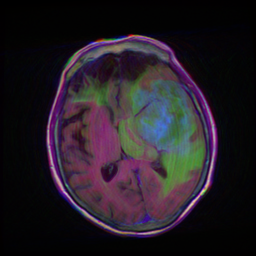

Tumor Segmentation


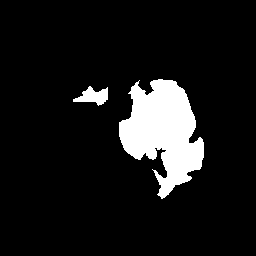

In [141]:
print("MRI")
cv2_imshow(training_images[30])
print("Tumor Segmentation")
cv2_imshow(training_masks[30])

# Dataset Normalization

In [133]:
x_train = training_images
x_test = validation_images
y_train = training_masks
y_test = validation_masks

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(578, 256, 256, 3)
(578, 256, 256, 3)
(63, 256, 256, 3)
(63, 256, 256, 3)


# Convolutional Autoencoder Architecture



*   Encoding:


> *   4 - 3x3 Convolutions
*   4 - 2x2 Max Pooling



*   Decoding



> *   5 - 3x3 Convolutions
*   4 - 2x2 Upsampling







In [147]:
input_img = Input(shape=(256, 256, 3))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])
autoencoder.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_269 (Conv2D)          (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 32, 32, 8)         0  

# Convolutional AutoEncoder Training



*   250 Epochs
*   32 Batch Size



In [162]:
autoencoder.fit(x_train, y_train,
                epochs=500,
                #batch_size=256,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 578 samples, validate on 63 samples
Epoch 1/500
578/578 [==============================] - 3s 5ms/step - loss: 0.0089 - acc: 0.9966 - val_loss: 0.0483 - val_acc: 0.9788
Epoch 2/500
578/578 [==============================] - 3s 5ms/step - loss: 0.0087 - acc: 0.9966 - val_loss: 0.0320 - val_acc: 0.9867
Epoch 3/500
578/578 [==============================] - 3s 5ms/step - loss: 0.0091 - acc: 0.9965 - val_loss: 0.0347 - val_acc: 0.9851
Epoch 4/500
578/578 [==============================] - 3s 5ms/step - loss: 0.0091 - acc: 0.9965 - val_loss: 0.0481 - val_acc: 0.9789
Epoch 5/500
578/578 [==============================] - 3s 5ms/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0285 - val_acc: 0.9889
Epoch 6/500
578/578 [==============================] - 3s 4ms/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0429 - val_acc: 0.9811
Epoch 7/500
578/578 [==============================] - 3s 4ms/step - loss: 0.0086 - acc: 0.9967 - val_loss: 0.0271 - val_acc: 0.9891
Epoch 8/500
578/578 [===

# Visualize Results

Prediction on validation dataset

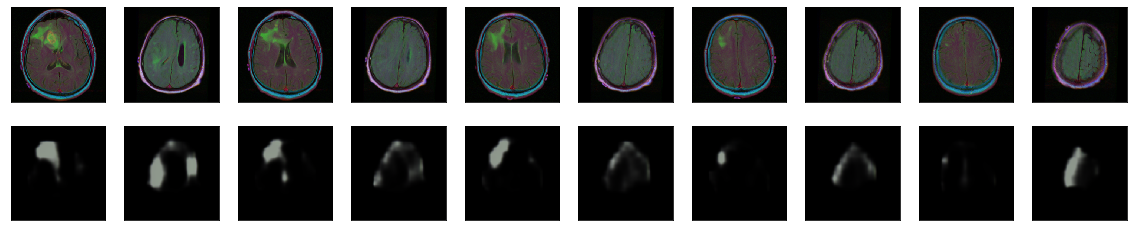

In [128]:
decoded_imgs = autoencoder.predict(x_test)
t = 256

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # MRI
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+30].reshape(t, t, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mask
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+30].reshape(t, t, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()